# MNIST DATASET
In this section, the goal will be to test the performance of the three implementation methods for the Hopfield model seen so far on a real dataset, MNIST, which contains handwritten digits.

The MNIST dataset consists in a 28x28 pixel grayscale images of handwritten digits (0–9) along with their corresponding labels.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df_train = pd.read_csv("data/mnist_train.csv")
df_test = pd.read_csv("data/mnist_test.csv")

# Check the shapes
print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)

Train shape: (60000, 785)
Test shape: (10000, 785)


The dataset is composed of 785 columns. From 1 to 784 represents each pixel of the image (28x28), while the last one (785) is the label containing the value of the corresponding digit.

Now I have to separate data in features and labels matrices and then normalize them.

In [3]:
# Divide features and labels
y_train = df_train["label"].values
x_train = df_train.drop("label", axis=1).values

y_test = df_test["label"].values
x_test = df_test.drop("label", axis=1).values

# Normalize the data
x_train = x_train/255
x_test = x_test/255

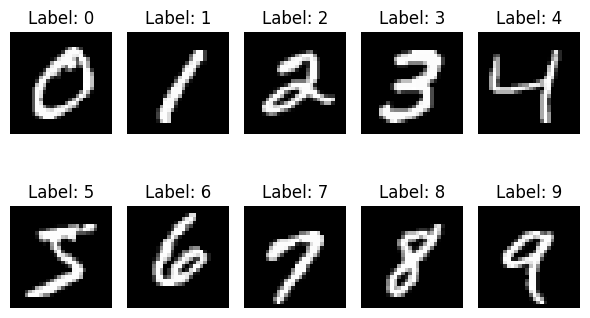

In [4]:
# Visualize images
fig, axs = plt.subplots(2, 5, figsize=(6, 4))
axs = axs.ravel()  

for i in range(10):

    # Visualize numbers from 0 to 9
    idx = np.where(y_train==i)[0][0]
    image = x_train[idx].reshape(28, 28)

    axs[i].imshow(image, cmap="grey")
    axs[i].set_title(f"Label: {i}")
    axs[i].axis('off') 

plt.tight_layout()
plt.show()

### Train the network with the three previous methods

### Corrupt the patterns and see if they are still recognizable

/var/folders/9p/sxfs2z3j2ln1p3kz5qdq03_w0000gn/T/ipykernel_29778/2235273431.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


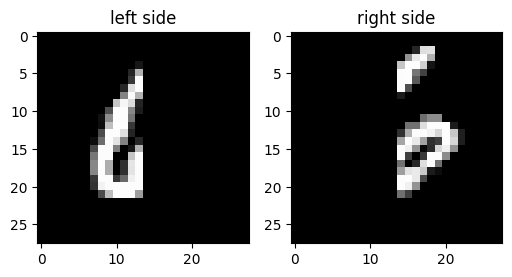

In [5]:
def cut_image(image, side="left"):
    """
    Cut an image at half putting to zero one of the two parts.

    image: image to corrupt
    side: decide which side of the picture keep
        - "left": keep the left side of the image
        - "right": keep the right side of the image
    """
    
    cut = image.shape[1]//2
    corrupted_image = np.copy(image)

    if side == "left":
        corrupted_image[:, cut:] = 0 # Put to zero the right side of the image
    
    elif side == "right":
        corrupted_image[:, :cut] = 0 # Put to zero the left side of the image

    return corrupted_image


# Just let's see if it works
idx = np.where(y_train == 6)[0][0]
original_image = x_train[idx].reshape(28, 28)

noisy_image1 = cut_image(original_image, "left")
noisy_image2 = cut_image(original_image, "right")

# Plot
plt, axs = plt.subplots(1, 2, figsize=(6, 3))
axs[0].imshow(noisy_image1, cmap="grey")
axs[0].set_title("left side")

axs[1].imshow(noisy_image2, cmap="grey")
axs[1].set_title("right side")

plt.show()